In [1]:
import sys
import torch
import global_variables as gv
import sys
import numpy as np
import matplotlib.pyplot as plt
import configparser
from FACTS_Modules.Model import model_factory
from FACTS_Modules.util import string2dtype_array
from FACTS_Modules.TADA import MakeGestScore
from facts_visualizations import single_trial_plots, multi_trial_plots
import os 
import pdb
import seaborn as sns

In [2]:
def simulator(theta):
    ini='DesignA_pert.ini'
    gFile='GesturalScores/KimetalOnlinepert2.G'
    config = configparser.ConfigParser()
    config.read(ini)

    # Replace the parameter value from ini file
    #pdb.set_trace()
    try:
        if theta.numel() > 1:
            config['SensoryNoise']['Somato_sensor_scale'] = str(theta[0].item())
        else:
            #pdb.set_trace()
            config['SensoryNoise']['Somato_sensor_scale'] = str(theta.item())
    except:
        pdb.set_trace()

    model = model_factory(config)
    #pdb.set_trace()
    if 'MultTrials' in config.sections(): 
        ntrials = int(config['MultTrials']['ntrials'])
        target_noise= float(config['MultTrials']['Target_noise'])
    else: 
        ntrials = 1
        target_noise = 0

    #pdb.set_trace()
    gest_name = gFile.split('/')[-1]
    np.random.seed(100)
    GestScore, ART, ms_frm, last_frm = MakeGestScore(gFile,target_noise)
    
    # initialize vectors to monitor position at each timestep
    a_record = np.empty([ntrials,last_frm,gv.a_dim])
    x_record = np.empty([ntrials,last_frm,gv.x_dim])
    formant_record = np.empty([ntrials,last_frm,3])
    shift_record = np.empty([ntrials,last_frm,3])
    a_tilde_record = np.empty([ntrials,last_frm,gv.a_dim])
    a_dot_record = np.empty([ntrials,last_frm,gv.a_dim])
    a_dotdot_record = np.empty([ntrials,last_frm,gv.a_dim])
    predict_formant_record = np.empty([ntrials,last_frm,3])

    #Check if catch trials (no perturbation) are specified in the config file
    if 'CatchTrials' in config.keys():
        catch_trials = string2dtype_array(config['CatchTrials']['catch_trials'], dtype='int')
        catch_types = string2dtype_array(config['CatchTrials']['catch_types'], dtype='int')
        if len(catch_trials) != len(catch_types):
            raise Exception("Catch trial and catch type lengths not matching, please check the config file.")
    else: catch_trials = np.array([])

    #pdb.set_trace()

    #Run FACTS for each trial
    for trial in range(ntrials):
        print("trial:", trial)
        #Gestural score (task)
        #pdb.set_trace()
        GestScore, ART, ms_frm, last_frm = MakeGestScore(gFile,target_noise)         #this is similar with MakeGest in the matlab version

        # initial condition
        x_tilde = string2dtype_array(config['InitialCondition']['x_tilde_init'],'float')
        a_tilde = string2dtype_array(config['InitialCondition']['a_tilde_init'],'float')
        a_actual = string2dtype_array(config['InitialCondition']['a_tilde_init'],'float')
        model.artic_sfc_law.reset_prejb() #save the initial artic-to-task model.

        if trial in catch_trials: catch = catch_types[np.where(catch_trials==trial)[0][0]]
        else: catch = False
        print("catch:", catch)
        
        for i_frm in range(last_frm):
            #model function runs FACTS by each frame
            x_tilde, a_tilde, a_actual, formants, formants_shifted, adotdot, y_hat = model.run_one_timestep(x_tilde, a_tilde, a_actual, GestScore, ART, ms_frm, i_frm, trial, catch)
            
            #save the FACTS results
            a_record[trial, i_frm,:] = a_actual[0:gv.a_dim]
            a_tilde_record[trial, i_frm,:] = a_tilde[0:gv.a_dim]
            a_dot_record[trial, i_frm,:] = a_tilde[gv.a_dim:]
            x_record[trial, i_frm,:] = x_tilde[0:gv.x_dim]
            formant_record[trial, i_frm,:] = formants
            predict_formant_record[trial, i_frm,:] = y_hat
            shift_record[trial, i_frm, :] = formants_shifted
            a_dotdot_record[trial, i_frm,:] = adotdot
    #pdb.set_trace()
    return formant_record[:,:,0].squeeze() 


## Run an example trails of FACTS, just to make sure out data look okay later
#### Change the ini process and covariance scale
from
process_scale = 0.01 
covariance_scale = 0.01 

to
process_scale = 0.0000001
covariance_scale = 0.0000001

In [3]:
# Print an example trial 
examples = []
mu1 = 0.00073
for i in range(1):
    example = simulator(torch.tensor([mu1]))
    examples.append(example)

Artic SFC Law Model Type:  lwpr
[ 5.35 17.59 25.89]
[-3999999.00062613   166666.66669271   166666.66669271   166666.66669271
   166666.66669271   166666.66669271   166666.66669271   166666.66669271
   166666.66669271   166666.66669271   166666.66669271   166666.66669271
   166666.66669271   166666.66669271   166666.66669271   166666.66669271
   166666.66669271   166666.66669271   166666.66669271   166666.66669271
   166666.66669271   166666.66669271   166666.66669271   166666.66669271
   166666.66669271]
Task State Estimator Model Type:  lwpr
trial: 0
catch: False


## Load observed data from Kyunghee's study

(1, 194)
(1797, 194)


Text(0, 0.5, 'F1 HZ')

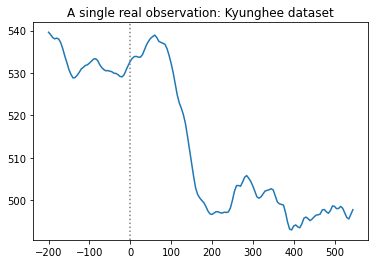

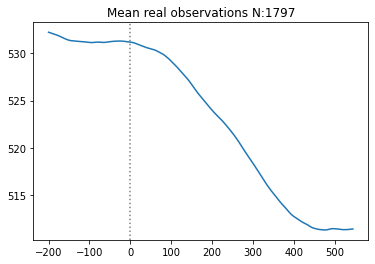

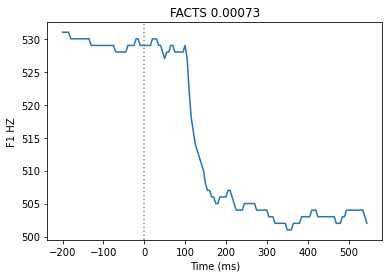

In [4]:
# Import real observed data
import scipy.io
example = examples[0]

trial_cells_times = scipy.io.loadmat('sbi_resources/formant_pert_time_cleaned.mat')['time_matrix'].T
trial_cells_mat = scipy.io.loadmat('sbi_resources/formant_pert_data_cleaned.mat')['cleaned_matrix'].T # 1797 x 194 == trials by time
print(trial_cells_times.shape)
print(trial_cells_mat.shape)
trial_cells_times = trial_cells_times[:,0:150]
trial_cells_mat = trial_cells_mat[:,0:150]

# # Alter the trial_cells so that they center to where FACTS centers
trial_cells_mat = trial_cells_mat + 531

# Plot and compare observed data to FACTS data
plt.plot(trial_cells_times[0,:]*1000, trial_cells_mat[729,:])
plt.axvline(x = 0, color = 'grey', ls=':')
plt.title('A single real observation: Kyunghee dataset')

plt.figure()
plt.plot(trial_cells_times[0,:]*1000, np.mean(trial_cells_mat, 0))
plt.axvline(x = 0, color = 'grey', ls=':')
plt.title(f'Mean real observations N:{(trial_cells_mat.shape[0])}')

# # Now realign so that 
plt.figure()
plt.title(f'FACTS {mu1}')
example_x = (np.arange(len(example))*5)-200
plt.plot(example_x,example)
plt.axvline(x = 0, color = 'grey', ls=':')
plt.xlabel('Time (ms)')
plt.ylabel('F1 HZ')

In [5]:
print(np.min(trial_cells_mat[729,:]))
print(np.min(np.mean(trial_cells_mat, 0)))
print(np.min(example))

493.03972341681293
511.3030736359036
501.0


## Perform SBI on FACTS parameter, and get log_prob of sample posterior

In [6]:
from sbi.inference import infer
from sbi import utils as utils
import pickle
# import facts_for_SBI

load_instead = False

# import your simulator, define your prior over the parameters
prior_mean = 0.000737
prior_min= [0.00001]
prior_mmax = [0.001] 
num_sim = 1000

# prior = torch.distributions.Uniform(torch.as_tensor(mmin), torch.as_tensor(mmax) )
if load_instead == False:
    prior = utils.torchutils.BoxUniform(torch.as_tensor(prior_min), torch.as_tensor(prior_mmax) )
    parameter_posterior = infer(simulator, prior, method='SNPE', num_simulations=num_sim, num_workers=6)
    with open(f'./sbi_resources/somatosensory_noise_posterior_{num_sim}.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
        pickle.dump([parameter_posterior], f)
    
else:
    file = open(f'./sbi_resources/somatosensory_noise_posterior_{num_sim}.pkl', 'rb')
    object_file = pickle.load(file)
    pdb.set_trace()
    file.close()


Artic SFC Law Model Type:  lwpr
[ 5.35 17.59 25.89]
[-3999999.00062613   166666.66669271   166666.66669271   166666.66669271
   166666.66669271   166666.66669271   166666.66669271   166666.66669271
   166666.66669271   166666.66669271   166666.66669271   166666.66669271
   166666.66669271   166666.66669271   166666.66669271   166666.66669271
   166666.66669271   166666.66669271   166666.66669271   166666.66669271
   166666.66669271   166666.66669271   166666.66669271   166666.66669271
   166666.66669271]
Task State Estimator Model Type:  lwpr
trial: 0
catch: False
Artic SFC Law Model Type:  lwpr
[ 5.35 17.59 25.89]
[-3999999.00062613   166666.66669271   166666.66669271   166666.66669271
   166666.66669271   166666.66669271   166666.66669271   166666.66669271
   166666.66669271   166666.66669271   166666.66669271   166666.66669271
   166666.66669271   166666.66669271   166666.66669271   166666.66669271
   166666.66669271   166666.66669271   166666.66669271   166666.66669271
   166666.66

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

KeyboardInterrupt: 

## Sample the posterior for a single point from Kyunghee's observations

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

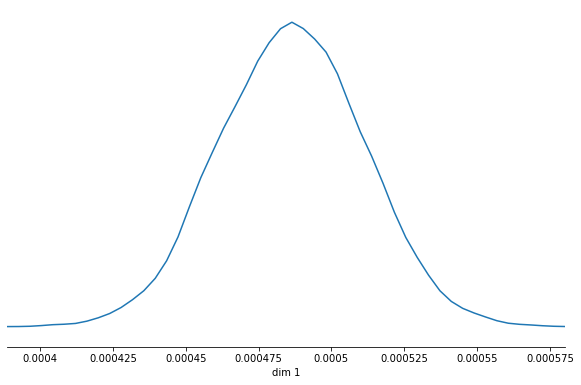

In [46]:
# https://astroautomata.com/blog/simulation-based-inference/
mean_trials = np.mean(trial_cells_mat, 0)
single_trial = trial_cells_mat[729]

samples = parameter_posterior.sample((10000,), x=single_trial)
log_probability = parameter_posterior.log_prob(samples, x=single_trial)
out = utils.pairplot(samples, fig_size=(10,6), upper='kde', diag='kde')

## Sample the posterior for a single data point from the FACTS model itself

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

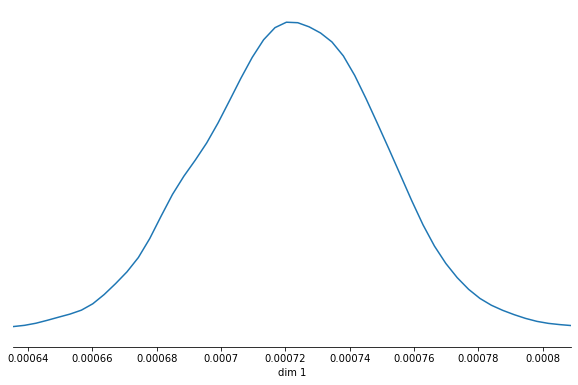

In [45]:
samples = parameter_posterior.sample((1000,), x=example)
log_probability = parameter_posterior.log_prob(samples, x=example)
out = utils.pairplot(samples, fig_size=(10,6), upper='kde', diag='kde')


In [40]:
print(trial_cells_mat.shape)

(1797, 150)


### Now plot for the mean of all trials

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

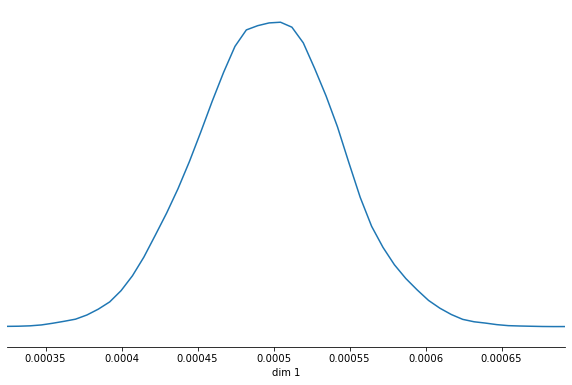

In [47]:
samples = parameter_posterior.sample((10000,), x=mean_trials)
log_probability = parameter_posterior.log_prob(samples, x=mean_trials)
out = utils.pairplot(samples, fig_size=(10,6), upper='kde', diag='kde')

In [43]:
# # Plot and compare observed data to FACTS data
# for ii in range(trial_cells_mat.shape[0]):
#     plt.figure()
#     plt.plot(trial_cells_times[0,:]*1000, trial_cells_mat[ii,:])
#     plt.axvline(x = 0, color = 'grey', ls=':')
#     plt.title(f'A single real observation: Kyunghee dataset {ii}')